We have 93 features describing products of Otto Group. This a multiple classification problem and the challenge is to classify products into correct categories. In this notebook, I focused on modelling. I experimented with **building an ensemble model** by training different models on the dataset and having each model make predictions individually. The metric I used is log loss.

The highlights are:
1. I selected three models: Random Forest, Logistic Regression, and LightGBM. Trained individually with **GridSearchCV** to find the best models.
2. I used **optimization algorithm to find the best ensemble weights** to combine three prediction results to a final prediction.
3. The scores of log loss for each modeling showed that the ensemble model was better than any individual model.

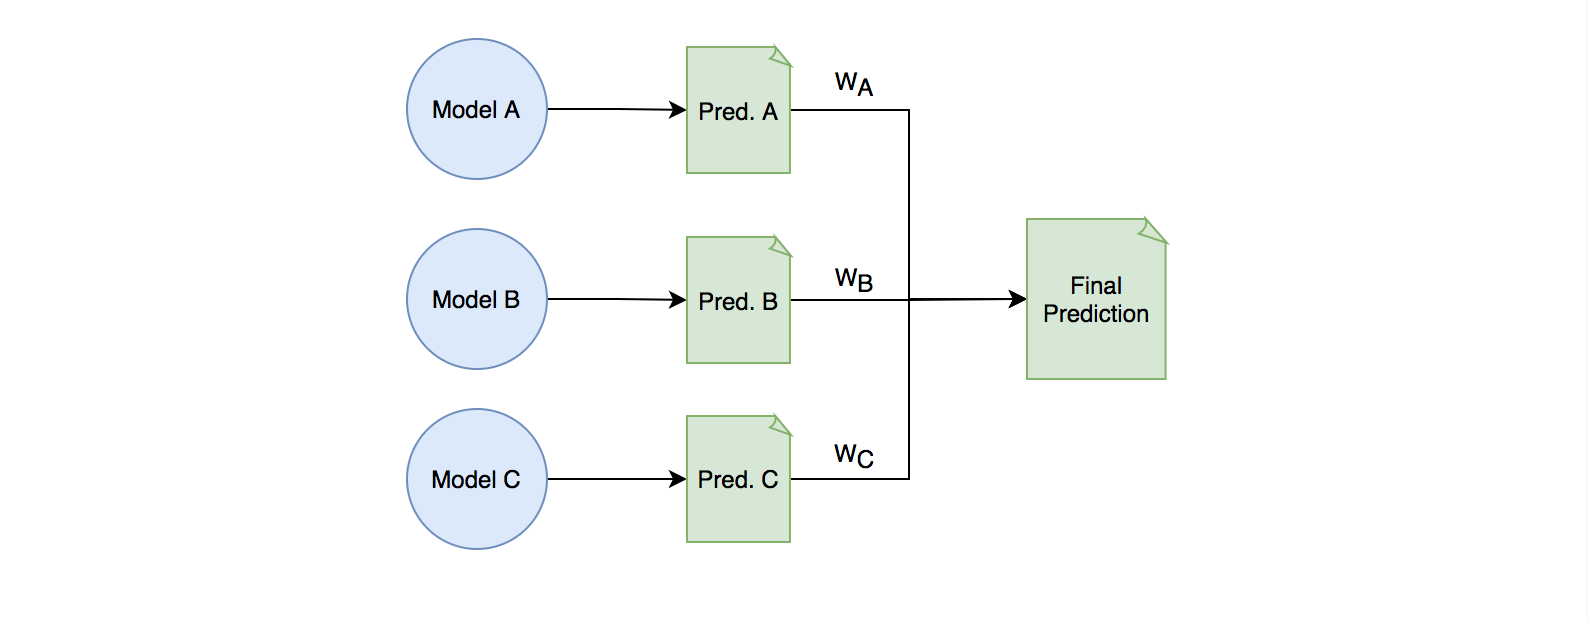

------
The outlines of this notebook:
- **Part0:** Imports
- **Part1:** The overviews of data
- **Part2:** Model training with default setting
- **Part3:** Hyperparameters tuning
    - 3.1 Random Forest
    - 3.2 Logistic Regression
    - 3.3 Light GBM
- **Part4:** Optimizing ensemble weights
- **Part5:** Submission

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Part0: Imports

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from scipy.optimize import minimize
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from lightgbm import LGBMClassifier

from sklearn.metrics import log_loss

## Part1: The overviews of data

In [ ]:
train = pd.read_csv('../input/otto-group-product-classification-challenge/train.csv')
test = pd.read_csv('../input/otto-group-product-classification-challenge/test.csv')
sample = pd.read_csv('../input/otto-group-product-classification-challenge/sampleSubmission.csv')

In [ ]:
train.head(3)

In [ ]:
train.info()

In [ ]:
g_target = train.groupby(['target']).size().reset_index(name='counts')

plt.figure(figsize=(12,5))
plt.title('The Distribution of Target in Training Dataset')
ax = sns.barplot(x="target", y="counts", data=g_target)
plt.show()

Prepare train/test dataset for model training

In [ ]:
target = train['target']
train.drop(['id','target'],axis=1,inplace=True)
train.shape

In [ ]:
testId = test['id']
test.drop('id',axis=1,inplace=True)
test.shape

## 2 Model training with default setting

In [ ]:
X = train
y = target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 7)

Define some common functions

In [ ]:
def get_accuracy_score(y_actual, y_pred):
    return accuracy_score(y_actual, y_pred)

def get_log_loss_score(y_actual, y_pred):
    return log_loss(y_actual, y_pred)

def train_test_model(clf, X_train, X_test, y_train, y_test, scoring_name='Accuracy'):
    print('%s training result:' % (str(clf)))
    clf.fit(X_train, y_train)
    score_train, score_test = 0, 0
    if scoring_name == 'Log_Loss':
        score_train = get_log_loss_score(y_train, clf.predict_proba(X_train))
        score_test = get_log_loss_score(y_test, clf.predict_proba(X_test))
    else:
        score_train = get_accuracy_score(y_train, clf.predict(X_train))
        score_test = get_accuracy_score(y_test, clf.predict(X_test))
    
    print('- %s on train dataset %.2f%%' % (scoring_name, score_train * 100))
    print('- %s on test dataset %.2f%%' % (scoring_name, score_test * 100))
    print()
    return {
        'clf': clf,
        'scores': {'train': score_train, 'test': score_test}
    }

def grid_search(clf, param_grid, param_name):
    # Grid Search for learning rate
    #learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
    #param_grid = dict(learning_rate = learning_rate, n_estimators = [150])
    kfold = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 7)
    grid_search = GridSearchCV(clf, param_grid, scoring = 'neg_log_loss'
                               , n_jobs = -1, cv = kfold, verbose = 1,  refit = True)
    result = grid_search.fit(X_train, y_train)
    print('The best paramter is %s ' % result.best_params_)
    print('The bcore is %f' % result.best_score_)
    print()
    plt.errorbar(param_grid[param_name], result.cv_results_['mean_test_score']
                 , yerr = result.cv_results_['std_test_score'])
    plt.xlabel(param_name)
    plt.ylabel('Log Loss')
    plt.show()

Train 3 models with default setting and set the evaluation metric as Log Loss.

In [ ]:
rfc = RandomForestClassifier(n_jobs=-1)
rfc_result = train_test_model(rfc, X_train, X_test, y_train ,y_test, scoring_name='Log_Loss')

lr = LogisticRegression(n_jobs=-1)
lr_result = train_test_model(lr, X_train, X_test, y_train ,y_test, scoring_name='Log_Loss')

lgbm = LGBMClassifier(n_jobs=-1, objective='multiclass')
lgbm_result = train_test_model(lgbm, X_train, X_test, y_train ,y_test, scoring_name='Log_Loss')

In [ ]:
df_scores = {
    'model': ['Random Forest', 'Random Forest'
              , 'Logistic Regression', 'Logistic Regression'
              , 'LightGBM', 'LightGBM'],
    'type': ['train', 'test', 'train', 'test', 'train', 'test'],
    'scores': [rfc_result['scores']['train'], rfc_result['scores']['test']
               , lr_result['scores']['train'], lr_result['scores']['test']
               , lgbm_result['scores']['train'], lgbm_result['scores']['test']
              ]
}

The smaller the Log-Loss is the better model performs and the chart shows the training/testing for each models. We can see that:
- Random Forest and XGBoost are overfitting.
- Althought Logistic Regression is not over/underfitting, its training & testing scores are the worst.

**ACTION-ITEM:** reduce overfitting by hyperparameter tuning in the next part.

In [ ]:
plt.figure(figsize=(12,5))
plt.title('The Log-Loss Scores')
ax = sns.barplot(x='model', y='scores', hue='type', data=df_scores)
plt.show()

## Part3: Hyperparameters tuning
I tuned a parameter at a time and plotted paires of Log-Loss score and its standard deviaton for each candidate value of parameter to find the best value by balancing Log-Loss scores and its standard deviaton.

In [ ]:
rfc = RandomForestClassifier(n_jobs=-1)
rfc_params = {'n_estimators': range(10, 100, 20), 'max_depth' : range(15, 50, 5)}

lr = LogisticRegression(n_jobs=-1)
lr_params = {'C': [0.1,1,10,100]}

lgbm = LGBMClassifier(n_jobs=-1, objective='multiclass')
lgbm_params = {'min_child_weight': [1, 2, 4, 8], 'max_depth': range(5, 30, 10), 'learning_rate': [0.01, 0.1, 0.2, 0.3]}

### 3.1 Random Forest

**n_estimators:** the maximum number of weak learner

In [ ]:
# RandomForest: n_estimators
params = {'n_estimators': rfc_params['n_estimators']}
grid_search(rfc, params, 'n_estimators')

**max_depth:** the maximum depth of the tree. (default: None)

In [ ]:
# RandomForest: max_depth
params = {'max_depth': rfc_params['max_depth'], 'n_estimators':[90]}
grid_search(rfc, params, 'max_depth')

### Logistic Regression

**C:** regularization strength

In [ ]:
# LogisticRegression: C
params = {'C': lr_params['C']}
grid_search(lr, params, 'C')

### Light GBM
**min_child_weight:** Minimum sum of instance weight (hessian) needed in a child (leaf).

In [ ]:
# LightGBM: min_child_weight
params = {'min_child_weight': lgbm_params['min_child_weight']}
grid_search(lgbm, params, 'min_child_weight')

**max_depth:** the maximum depth of the tree. 

In [ ]:
# LightGBM: max_depth
params = {'max_depth': lgbm_params['max_depth'], 'min_child_weight': [4]}
grid_search(lgbm, params, 'max_depth')

**learning_rate** 

In [ ]:
# LightGBM: learning_rate
params = {'learning_rate': lgbm_params['learning_rate'], 'min_child_weight': [4], 'max_depth':[15]}
grid_search(lgbm, params, 'learning_rate')

Next, let's evaluate the performance of the tuned models.

In [ ]:
clfs = []

rfc = RandomForestClassifier(n_jobs=-1, n_estimators=90, max_depth=30)
rfc_result_post = train_test_model(rfc, X_train, X_test, y_train ,y_test, scoring_name='Log_Loss')
clfs.append(rfc_result_post['clf'])

lr = LogisticRegression(n_jobs=-1, C=0.1)
lr_result_post = train_test_model(lr, X_train, X_test, y_train ,y_test, scoring_name='Log_Loss')
clfs.append(lr_result_post['clf'])

lgbm = LGBMClassifier(n_jobs=-1, objective='multiclass'
                     , min_child_weight=4, max_depth = 15, learning_rate = 0.1)
lgbm_result_post = train_test_model(lgbm, X_train, X_test, y_train ,y_test, scoring_name='Log_Loss')
clfs.append(lgbm_result_post['clf'])

In [ ]:
df_rfc = {
    'name': ['default_model', 'default_model', 'tuned_model', 'tuned_model'],
    'type': ['train', 'test', 'train', 'test'],
    'scores': [rfc_result['scores']['train'], rfc_result['scores']['test']
               , rfc_result_post['scores']['train'], rfc_result_post['scores']['test']
              ]
}

df_lr = {
    'name': ['default_model', 'default_model', 'tuned_model', 'tuned_model'],
    'type': ['train', 'test', 'train', 'test'],
    'scores': [lr_result['scores']['train'], lr_result['scores']['test']
               , lr_result_post['scores']['train'], lr_result_post['scores']['test']
              ]
}

df_lgbm = {
    'name': ['default_model', 'default_model', 'tuned_model', 'tuned_model'],
    'type': ['train', 'test', 'train', 'test'],
    'scores': [lgbm_result['scores']['train'], lgbm_result['scores']['test']
               , lgbm_result_post['scores']['train'], lgbm_result_post['scores']['test']
              ]
}

The charts below show the scores of Log-Loss. The gaps between train and test scores were smaller after hyperparameter tuning. The tuned models were less overfitting. However, I still had room to do further improvement. 

In [ ]:
plt.figure(figsize=(16, 5))

plt.subplot(1, 3, 1)
plt.title('Log-Loss Scores for Random Forest')
ax = sns.barplot(x='name', y='scores', hue='type', data=df_rfc)

plt.subplot(1, 3, 2)
plt.title('Log-Loss Scores for Logistic Regression')
ax = sns.barplot(x='name', y='scores', hue='type', data=df_lr)

plt.subplot(1, 3, 3)
plt.title('Log-Loss Scores for Light GBM')
ax = sns.barplot(x='name', y='scores', hue='type', data=df_lgbm)
plt.show()

## Part4: Optimizing ensemble weights
I used optimization algorithm to find the best weights to ensamble three models.

In [ ]:
predictions = []
for clf in clfs:
    predictions.append(clf.predict_proba(X_test))

def log_loss_func(weights):
    ''' scipy minimize will pass the weights as a numpy array '''
    final_prediction = 0
    for weight, prediction in zip(weights, predictions):
            final_prediction += weight*prediction

    return log_loss(y_test, final_prediction)
    
#the algorithms need a starting value, right not we chose 0.5 for all weights
#its better to choose many random starting points and run minimize a few times
starting_values = [0.5 for i in range(len(predictions))]
#adding constraints and a different solver
cons = ({'type':'eq','fun':lambda w: 1-sum(w)})
#weights are bound between 0 and 1
bounds = [(0,1)]*len(predictions)

res = minimize(log_loss_func, starting_values, method='SLSQP', bounds=bounds, constraints=cons)

print('Ensamble Score: {best_score}'.format(best_score=res['fun']))
print('Best Weights: {weights}'.format(weights=res['x']))

The table below shows Log-Loss. I learned that the ensembling model was better than three other individual models.

In [ ]:
df_summary = pd.DataFrame(data={
    'models': ['Random Forest(Tuned)', 'Logistic Regression(Tuned)'
              , 'Light GBM(Tuned)', 'Ensembling Model'],
    'scores': [rfc_result_post['scores']['test']
               , lr_result_post['scores']['test']
               , lgbm_result_post['scores']['test']
               , res['fun']
              ]
}) 
df_summary

## Part5: Submission

In [ ]:
for clf in clfs:
    preds = clf.predict_proba(test)
    lpreds = clf.predict_proba(test)
    gpreds = clf.predict_proba(test)
    xpreds = clf.predict_proba(test)

In [ ]:
coef_1 = res['x'][0] 
coef_2 = res['x'][1] 
coef_3 = res['x'][2]
finalPreds = coef_1*preds + coef_2*lpreds + coef_3*xpreds

In [ ]:
pred = pd.DataFrame(finalPreds, index=sample.id.values, columns=sample.columns[1:])
pred.to_csv('prediction.csv', index_label='id')

This competition has already ended, but we still can submit our predictions to see the scores. Top places have score of 0.38.

My ensemble model got a score of 0.48983.